In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39607")
client

<Client: 'tcp://127.0.0.1:39607' processes=8 threads=32, memory=125.87 GiB>

In [34]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xbootstrap import block_bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
spec = '/tank/spectre/tuchida/NA-wavelets/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -19.8
yNstart = 10
yend = 50

tchunk = 1
xchunk = 200
ychunk = 200

ntheta = 36
xo = 50e3

In [5]:
dnf = 2160
nfile = 73
years = np.arange(1963,2013,dtype=int)
ntimes = (np.arange(790560,8672400+dnf,dnf).reshape(len(years),nfile) 
          - dnf)
dd = 0
yystart = 4
ntimes[yystart,dd:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:
        dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                                      % (year)), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn',], 
                              delta_t=2e2, iters=itime                              
                             ).isel(time=0,Z=18,Zl=18,Zp1=slice(18,20)
                                   ).chunk({'YC':ychunk,'YG':ychunk,
                                            'XC':xchunk,'XG':xchunk})
        coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",  "left" : "XG"},
        "Y": {"center": "YC",  "left" : "YG"},
        # "Z": {"center": "layer",  "outer": "layerp1", 
        #       "left"  : "layerl", "inner": "layerp0"
        #      }
       }
        grid = Grid(dsm, periodic=['X'],
                    coords=coords)
        
        for imemb in nmembs:
            if imemb == nmembs[0]:
                ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                             % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn',], 
                                     delta_t=2e2, iters=itime                              
                                    ).isel(Z=18,Zl=18,Zp1=slice(18,20)
                                          ).chunk({'YC':ychunk,'YG':ychunk,
                                                   'XC':xchunk,'XG':xchunk})
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                                            % (imemb,year)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn',], 
                                                    delta_t=2e2, iters=itime                              
                                                   ).isel(Z=18,Zl=18,Zp1=slice(18,20)
                                                         ).chunk({'YC':ychunk,'YG':ychunk,
                                                                  'XC':xchunk,'XG':xchunk})
                               ], 'nmemb')
        
        dse = ds.isel(time=0) - dsm
        dse.coords['nmemb'] = nmembs
        
        EKE = (grid.interp(dse.UVEL**2,'X')
               + grid.interp(dse.VVEL**2,'Y',boundary='extend') 
              ).where(dse.maskC!=0.).fillna(0.).reset_coords(drop=True).compute() * .5
        EKE.coords['nmemb'] = range(48)
        
        dse.close()
        dsm.close()
        ds.close()
        print(itime)
    yys += 1

1419120


In [7]:
EKE

<xarray.DataArray (nmemb: 48, YC: 900, XC: 1000)>
array([[[1.28908620e-11, 1.29097844e-11, 1.28908620e-11, ...,
         1.29003214e-11, 1.29003214e-11, 1.28908620e-11],
        [8.37888092e-06, 5.14262956e-06, 3.15277111e-06, ...,
         1.61869175e-05, 1.46634911e-05, 1.19327706e-05],
        [1.44379039e-04, 1.15919007e-04, 9.11644674e-05, ...,
         2.26163436e-04, 1.98943861e-04, 1.71900188e-04],
        ...,
        [5.03165182e-03, 4.30066651e-03, 3.28824017e-03, ...,
         4.32664994e-03, 5.03845420e-03, 5.29538607e-03],
        [3.74756433e-04, 4.36823437e-04, 4.55764501e-04, ...,
         1.45670900e-04, 2.15595006e-04, 2.94693571e-04],
        [1.28932264e-11, 1.28955908e-11, 1.28955908e-11, ...,
         1.28955908e-11, 1.28932264e-11, 1.28938917e-11]],

       [[1.28908620e-11, 1.29097844e-11, 1.28908620e-11, ...,
         1.29003214e-11, 1.29003214e-11, 1.28908620e-11],
        [4.50301195e-06, 4.02930482e-06, 4.08630376e-06, ...,
         6.63882474e-06, 5.88635703e-06, 5.05466824e-06],
        [2.40404479e-05, 2.37819986e-05, 2.50081266e-05, ...,
         2.69823558e-05, 2.45163264e-05, 2.36224914e-05],
...
        [8.08580196e-04, 1.33004249e-03, 2.01956229e-03, ...,
         3.27739585e-03, 1.43827684e-03, 7.33072055e-04],
        [8.26496671e-06, 3.57828867e-05, 1.07865868e-04, ...,
         3.61902436e-04, 1.50555279e-04, 3.97703370e-05],
        [1.28932264e-11, 1.28908620e-11, 1.28908620e-11, ...,
         1.28908620e-11, 1.28955908e-11, 1.28939654e-11]],

       [[1.28908620e-11, 1.28908620e-11, 1.28908620e-11, ...,
         1.28908620e-11, 1.28908620e-11, 1.29003214e-11],
        [3.33732260e-07, 1.94783794e-07, 1.31674994e-07, ...,
         4.90018465e-06, 2.15980117e-06, 8.39365612e-07],
        [4.53370158e-05, 3.27931921e-05, 2.66559000e-05, ...,
         1.39293377e-04, 9.75499133e-05, 6.63394821e-05],
        ...,
        [6.78655124e-05, 6.40720245e-05, 5.92061224e-05, ...,
         2.87098101e-05, 4.79364498e-05, 6.25665998e-05],
        [5.86536680e-06, 1.12925618e-05, 1.47987703e-05, ...,
         4.56163161e-06, 2.20325592e-06, 2.03423110e-06],
        [1.28932264e-11, 1.28908620e-11, 1.28908620e-11, ...,
         1.28908620e-11, 1.28955908e-11, 1.28939654e-11]]], dtype=float32)
Coordinates:
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46 47

In [10]:
bs12 = xr.ones_like(EKE.isel(nmemb=slice(None,2))[:,1::10,::10]) * np.nan
bs24 = xr.ones_like(EKE.isel(nmemb=slice(None,2))[:,1::10,::10]) * np.nan
bs = xr.ones_like(EKE.isel(nmemb=slice(None,2))[:,1::10,::10]) * np.nan

rng = np.random.default_rng()

for j in range(len(EKE.YC[1::10])):
    for i in range(len(EKE.XC[::10])):
        if dse.maskC[1::10,::10].isel(YC=j,XC=i).values != 0.:
            datas = (EKE[:,1::10,::10].isel(nmemb=slice(None,12),YC=j,XC=i).values,
                    )
            ci = bootstrap(datas, np.mean, confidence_level=0.9,
                           n_resamples=1000,
                           random_state=rng
                          ).confidence_interval
            bs12[dict(YC=j,XC=i)] = np.array([ci.low, ci.high])
            datas = (EKE[:,1::10,::10].isel(nmemb=slice(None,24),YC=j,XC=i).values,
                    )
            ci = bootstrap(datas, np.mean, confidence_level=0.9,
                           n_resamples=1000,
                           random_state=rng
                          ).confidence_interval
            bs24[dict(YC=j,XC=i)] = np.array([ci.low, ci.high])
            datas = (EKE[:,1::10,::10].isel(YC=j,XC=i).values,
                    )
            ci = bootstrap(datas, np.mean, confidence_level=0.9,
                           n_resamples=1000,
                           random_state=rng
                          ).confidence_interval
            bs[dict(YC=j,XC=i)] = np.array([ci.low, ci.high])
    print(j)
bs12

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


<xarray.DataArray (nmemb: 2, YC: 90, XC: 100)>
array([[[4.0288640e-05, 1.0798187e-05, 2.6367030e-07, ...,
         2.7049946e-06, 3.1702280e-06, 1.3337106e-05],
        [2.7465849e-04, 3.1388432e-04, 2.0208862e-04, ...,
         4.5197044e-04, 4.6948151e-04, 2.7534142e-04],
        [2.9751554e-04, 2.2124570e-04, 2.4415104e-04, ...,
         4.0321675e-04, 5.9613131e-04, 2.0107090e-04],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan, 4.2367763e-05],
        [          nan,           nan,           nan, ...,
         2.2732909e-03,           nan,           nan],
        [1.2037531e-03,           nan,           nan, ...,
         5.0151334e-03, 5.6589977e-03, 2.3999168e-03]],

       [[1.6164035e-04, 8.9518711e-05, 8.4028761e-07, ...,
         8.6377067e-06, 1.0098913e-05, 3.0596097e-05],
        [5.1137421e-04, 9.1050816e-04, 5.7471963e-04, ...,
         8.9332159e-04, 8.8627462e-04, 7.3291769e-04],
        [1.0240125e-03, 5.7196780e-04, 5.2638934e-04, ...,
         1.2985577e-03, 1.2880042e-03, 5.9381517e-04],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan, 1.5044214e-04],
        [          nan,           nan,           nan, ...,
         6.9424245e-03,           nan,           nan],
        [2.4914870e-03,           nan,           nan, ...,
         1.0010849e-02, 1.4225743e-02, 3.7321977e-03]]], dtype=float32)
Coordinates:
  * XC       (XC) >f4 262.0 262.9 263.7 264.6 265.4 ... 344.6 345.5 346.3 347.2
  * YC       (YC) >f4 -19.83 -19.0 -18.17 -17.33 ... 51.83 52.67 53.5 54.33
  * nmemb    (nmemb) int64 0 1

In [11]:
dsave = bs12.to_dataset(name='12')
dsave['24'] = bs24
dsave['48'] = bs
dsave.chunk({'nmemb':-1,'YC':100,'XC':100}
           ).to_zarr(op.join(spec,'EKE_ci_every10.zarr'))
dsave

<xarray.Dataset>
Dimensions:  (XC: 100, YC: 90, nmemb: 2)
Coordinates:
  * XC       (XC) >f4 262.0 262.9 263.7 264.6 265.4 ... 344.6 345.5 346.3 347.2
  * YC       (YC) >f4 -19.83 -19.0 -18.17 -17.33 ... 51.83 52.67 53.5 54.33
  * nmemb    (nmemb) int64 0 1
Data variables:
    12       (nmemb, YC, XC) float32 4.029e-05 1.08e-05 ... 0.01423 0.003732
    24       (nmemb, YC, XC) float32 4.09e-05 1.385e-05 ... 0.01017 0.006212
    48       (nmemb, YC, XC) float32 4.285e-05 1.488e-05 ... 0.008576 0.008962

In [31]:
bs36 = xr.ones_like(EKE.isel(nmemb=slice(None,2))[:,1::10,::10]) * np.nan

rng = np.random.default_rng()

for j in range(len(EKE.YC[1::10])):
    for i in range(len(EKE.XC[::10])):
        if dse.maskC[1::10,::10].isel(YC=j,XC=i).values != 0.:
            datas = (EKE[:,1::10,::10].isel(nmemb=slice(None,36),YC=j,XC=i).values,
                    )
            ci = bootstrap(datas, np.mean, confidence_level=0.9,
                           n_resamples=1000,
                           random_state=rng
                          ).confidence_interval
            bs36[dict(YC=j,XC=i)] = np.array([ci.low, ci.high])
    print(j)
bs36

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


<xarray.DataArray (nmemb: 2, YC: 90, XC: 100)>
array([[[4.2845430e-05, 1.2680275e-05, 5.6392588e-07, ...,
         2.7590895e-06, 5.1468701e-06, 1.8443847e-05],
        [2.7141077e-04, 2.3552062e-04, 2.5771465e-04, ...,
         5.2130007e-04, 5.2194978e-04, 3.6700835e-04],
        [4.2728198e-04, 4.2680814e-04, 4.2730593e-04, ...,
         5.0170155e-04, 6.2538055e-04, 3.9326664e-04],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan, 6.0784798e-05],
        [          nan,           nan,           nan, ...,
         4.2122300e-03,           nan,           nan],
        [1.7810552e-03,           nan,           nan, ...,
         8.6004501e-03, 5.6565935e-03, 3.6026945e-03]],

       [[9.1594709e-05, 3.8736143e-05, 1.0812937e-06, ...,
         7.0529072e-06, 1.1717619e-05, 3.2895019e-05],
        [3.9910918e-04, 4.8343002e-04, 4.3245815e-04, ...,
         9.4162690e-04, 8.1339281e-04, 6.1896356e-04],
        [8.7561272e-04, 7.6552411e-04, 7.5607788e-04, ...,
         9.3597855e-04, 9.7536645e-04, 6.4609922e-04],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan, 1.1094130e-04],
        [          nan,           nan,           nan, ...,
         9.0571484e-03,           nan,           nan],
        [2.9862798e-03,           nan,           nan, ...,
         1.3557826e-02, 9.3787918e-03, 5.8165444e-03]]], dtype=float32)
Coordinates:
  * XC       (XC) >f4 262.0 262.9 263.7 264.6 265.4 ... 344.6 345.5 346.3 347.2
  * YC       (YC) >f4 -19.83 -19.0 -18.17 -17.33 ... 51.83 52.67 53.5 54.33
  * nmemb    (nmemb) int64 0 1

Task exception was never retrieved
future: <Task finished name='Task-148696' coro=<Client._gather.<locals>.wait() done, defined at /tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit


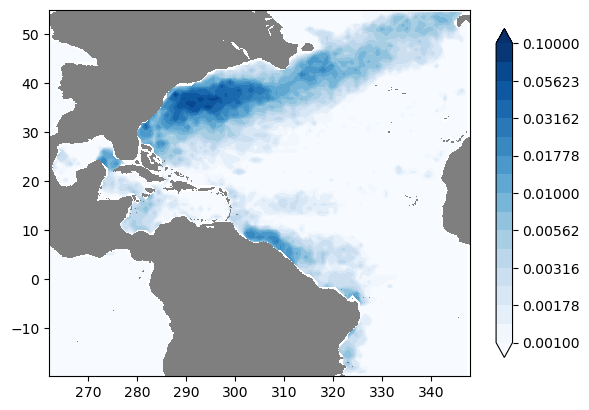

In [56]:
dsf = xr.open_zarr(op.join(spec,'EKE_ci_every10.zarr'))
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                                      % (year)), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn',], 
                              delta_t=2e2, iters=itime                              
                             ).isel(time=0,Z=18,Zl=18,Zp1=slice(18,20)
                                   ).chunk({'YC':ychunk,'YG':ychunk,
                                            'XC':xchunk,'XG':xchunk})

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

cs = ax.contourf(dsf.XC, dsf.YC, 
                 dsf['48'].diff('nmemb').isel(nmemb=0),
                 levels=np.logspace(-3,-1,17), cmap='Blues',
                 extend='both',
                 norm=clr.LogNorm(vmin=1e-3, vmax=1e-1)
                )
# cs = ax.contourf(dsf.XC, dsf.YC, 
#                  bs36.diff('nmemb').isel(nmemb=0),
#                  levels=np.logspace(-3,-1,17), cmap='Blues',
#                  extend='both',
#                  norm=clr.LogNorm(vmin=1e-3, vmax=1e-1)
#              )
for c in cs.collections:
    c.set_rasterized(True)
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(cs, ax=ax, shrink=.7)
plt.savefig(op.join(spec,'Figs/EKE_ci.pdf'))

In [ ]:
_, bs = block_bootstrap(
    EKE,
    EKE,
    blocks={"nmemb": 4, "YC": 100, "XC":100},
    n_iteration=1000,
    exclude_dims=[[],["YC","XC"]],
    circular=True,
)
bs

In [9]:
EKE.reset_coords(drop=True)

<xarray.DataArray (nmemb: 48, YC: 900, XC: 1000)>
array([[[1.28908620e-11, 1.29097844e-11, 1.28908620e-11, ...,
         1.29003214e-11, 1.29003214e-11, 1.28908620e-11],
        [8.37888092e-06, 5.14262956e-06, 3.15277111e-06, ...,
         1.61869175e-05, 1.46634911e-05, 1.19327706e-05],
        [1.44379039e-04, 1.15919007e-04, 9.11644674e-05, ...,
         2.26163436e-04, 1.98943861e-04, 1.71900188e-04],
        ...,
        [5.03165182e-03, 4.30066651e-03, 3.28824017e-03, ...,
         4.32664994e-03, 5.03845420e-03, 5.29538607e-03],
        [3.74756433e-04, 4.36823437e-04, 4.55764501e-04, ...,
         1.45670900e-04, 2.15595006e-04, 2.94693571e-04],
        [1.28932264e-11, 1.28955908e-11, 1.28955908e-11, ...,
         1.28955908e-11, 1.28932264e-11, 1.28938917e-11]],

       [[1.28908620e-11, 1.29097844e-11, 1.28908620e-11, ...,
         1.29003214e-11, 1.29003214e-11, 1.28908620e-11],
        [4.50301195e-06, 4.02930482e-06, 4.08630376e-06, ...,
         6.63882474e-06, 5.88635703e-06, 5.05466824e-06],
        [2.40404479e-05, 2.37819986e-05, 2.50081266e-05, ...,
         2.69823558e-05, 2.45163264e-05, 2.36224914e-05],
...
        [8.08580196e-04, 1.33004249e-03, 2.01956229e-03, ...,
         3.27739585e-03, 1.43827684e-03, 7.33072055e-04],
        [8.26496671e-06, 3.57828867e-05, 1.07865868e-04, ...,
         3.61902436e-04, 1.50555279e-04, 3.97703370e-05],
        [1.28932264e-11, 1.28908620e-11, 1.28908620e-11, ...,
         1.28908620e-11, 1.28955908e-11, 1.28939654e-11]],

       [[1.28908620e-11, 1.28908620e-11, 1.28908620e-11, ...,
         1.28908620e-11, 1.28908620e-11, 1.29003214e-11],
        [3.33732260e-07, 1.94783794e-07, 1.31674994e-07, ...,
         4.90018465e-06, 2.15980117e-06, 8.39365612e-07],
        [4.53370158e-05, 3.27931921e-05, 2.66559000e-05, ...,
         1.39293377e-04, 9.75499133e-05, 6.63394821e-05],
        ...,
        [6.78655124e-05, 6.40720245e-05, 5.92061224e-05, ...,
         2.87098101e-05, 4.79364498e-05, 6.25665998e-05],
        [5.86536680e-06, 1.12925618e-05, 1.47987703e-05, ...,
         4.56163161e-06, 2.20325592e-06, 2.03423110e-06],
        [1.28932264e-11, 1.28908620e-11, 1.28908620e-11, ...,
         1.28908620e-11, 1.28955908e-11, 1.28939654e-11]]], dtype=float32)
Coordinates:
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
Dimensions without coordinates: nmemb